### Purpose

Test the WaveNet network on `pseudoGR` features. Demonstrate the difference between `categorical` loss, `ordinal` loss, and a combination.

In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix

from coremdlr.viz import model_plots
from coremdlr.models import NetworkModel
from coremdlr.datasets import DepthSequenceGenerator, FaciesDataset


import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#well_names = ["205-21b-3", "204-20-6a", "204-24a-6", "204-20-1Z", "204-19-6", "204-20-1"]
well_names = [ "204-19-7", "204-20-1","204-20-1Z","204-20-2","204-20-3", "205-21b-3", "204-24a-7" ]

loss_options = ('categorical_crossentropy',
                'ordinal_squared_error',
                {'categorical_crossentropy': 0.2,
                 'ordinal_squared_error': 0.8})

wavenet_model_args = {
    'feature' : 'pseudoGR',
    'network' : 'wavenet',
    'sequence_size' : 128,
    'network_args' : {
        'num_blocks' : 20,
        'block_filters' : 128,
        'residual_filters' : 64,
        'output_resolution' : 32,
        'dropout_rate' : 0.5,
    },
    'optimizer_args' : {
        'optimizer' : 'Adam'
    }
}

fit_args = {
    'batch_size' : 16,
    'epochs' : 15,
    'class_weighted': True
}


In [5]:
np.type(well_names)

AttributeError: module 'numpy' has no attribute 'type'



TESTING WITH TEST WELL: 204-19-7


Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:79: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('pseudoGR', (11210, 32, 8))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('pseudoGR', (1917, 32, 8))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (2940,)), ('top', (2940,)), ('base', (2940,)), ('pseudoGR', (2940, 32, 8))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (10906,)), ('top',

/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:79: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('pseudoGR', (9807, 32, 8))]

MODELING WITH LOSS: categorical_crossentropy

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 4096, 64)     3648        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4096, 128)    24704       conv1d[0][0]                     
______________________________________________________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
49/49 [==============================] - 32s 647ms/step - loss: 6.8286 - acc: 0.2397 - val_loss: 4.9973 - val_acc: 0.4664
Epoch 2/15
49/49 [==============================] - 19s 391ms/step - loss: 6.5772 - acc: 0.2878 - val_loss: 4.9973 - val_acc: 0.4664
Epoch 3/15
49/49 [==============================] - 19s 392ms/step - loss: 6.4695 - acc: 0.2992 - val_loss: 4.9973 - val_acc: 0.4664
Epoch 4/15
49/49 [==============================] - 19s 393ms/step - loss: 6.4905 - acc: 0.2974 - val_loss: 4.9973 - val_acc: 0.4664
Epoch 5/15
49/49 [==============================] - 19s 394ms/step - loss: 6.5875 - acc: 0.2873 - val_loss: 4.9973 - val_acc: 0.4664
Epoch 6/15
49/49 [==============================] - 19s 394ms/step - loss: 6.5790 - acc: 0.2873 - val_loss: 4.9973 - val_acc: 0.4664
Epoch 7/15
49/49 [==============================] - 20s 399ms/step - loss: 6.4952 - acc: 0.2967 - val_loss: 4.9973 - val_acc: 0.4664
Epoch 8/1

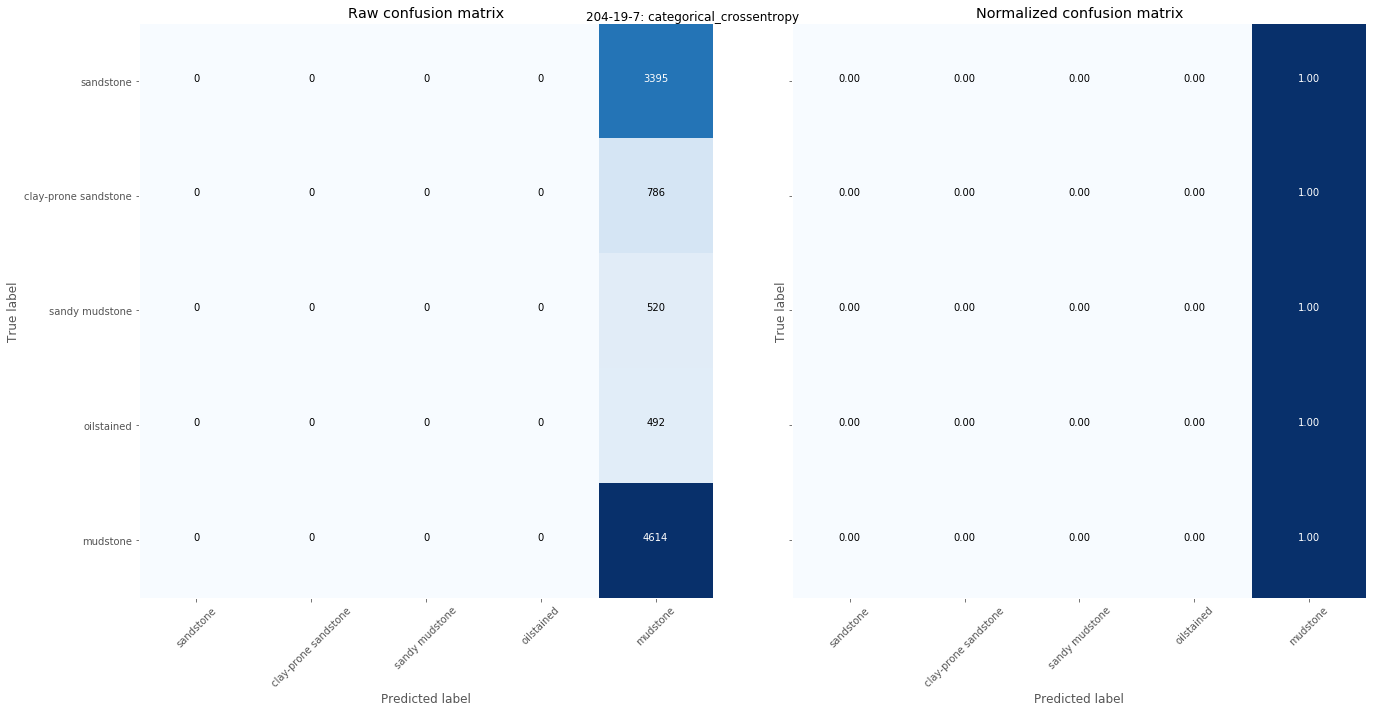


MODELING WITH LOSS: ordinal_squared_error

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_66 (Conv1D)              (None, 4096, 64)     3648        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, 4096, 128)    24704       conv1d_66[0][0]                  
__________________________________________________________________________________________________
conv1d_68 (Conv1D)              (None, 4096, 128)    24704       conv1d_66[0][0]                  
_________________________________________________________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
49/49 [==============================] - 31s 639ms/step - loss: 6.4974 - acc: 0.2866 - val_loss: 4.9973 - val_acc: 0.4664
Epoch 2/15
49/49 [==============================] - 20s 413ms/step - loss: 6.5782 - acc: 0.2873 - val_loss: 4.9973 - val_acc: 0.4664
Epoch 3/15
49/49 [==============================] - 20s 415ms/step - loss: 6.5817 - acc: 0.2873 - val_loss: 4.9973 - val_acc: 0.4664
Epoch 4/15
49/49 [==============================] - 20s 411ms/step - loss: 6.5521 - acc: 0.2906 - val_loss: 4.9973 - val_acc: 0.4664
Epoch 5/15
49/49 [==============================] - 20s 414ms/step - loss: 6.5807 - acc: 0.2873 - val_loss: 4.9973 - val_acc: 0.4664
Epoch 6/15
49/49 [==============================] - 20s 417ms/step - loss: 6.5856 - acc: 0.2873 - val_loss: 4.9973 - val_acc: 0.4664
Epoch 7/15
49/49 [==============================] - 20s 414ms/step - loss: 6.5803 - acc: 0.2879 - val_loss: 4.9973 - val_acc: 0.4664
Epoch 8/1

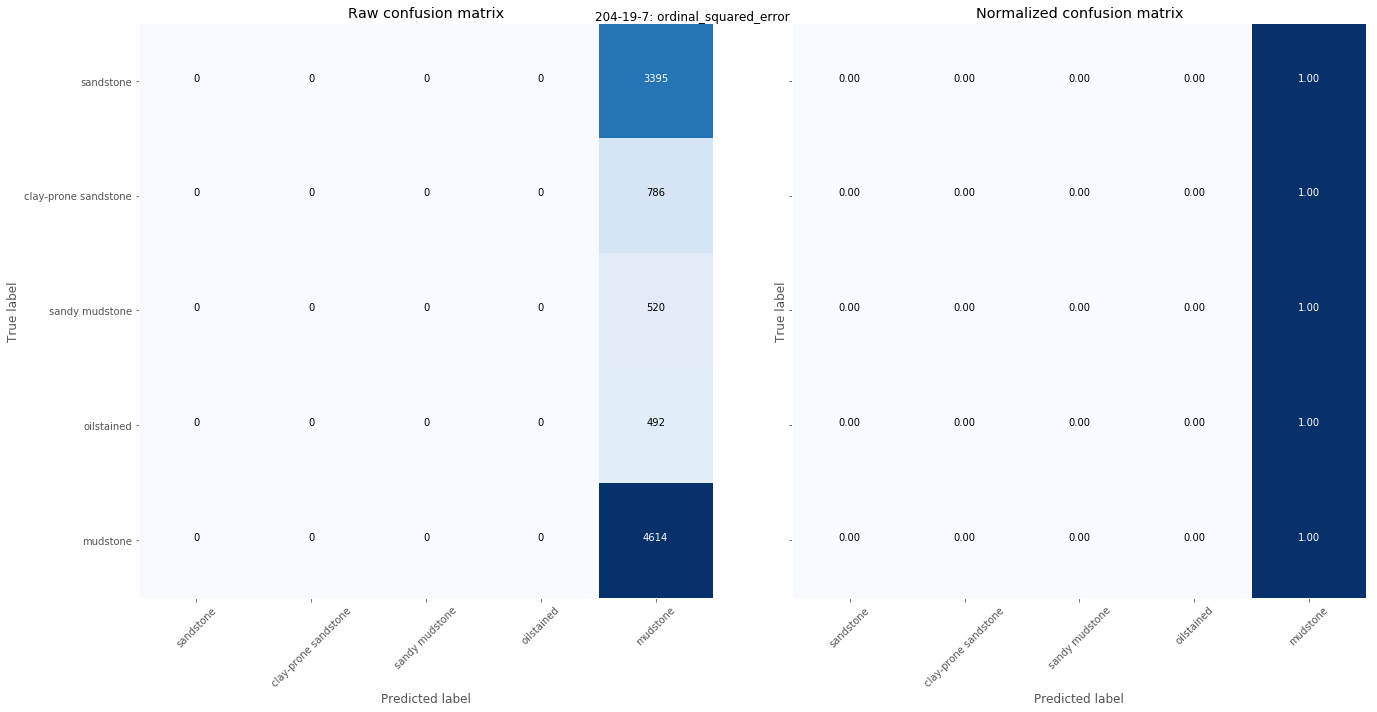


MODELING WITH LOSS: {'categorical_crossentropy': 0.2, 'ordinal_squared_error': 0.8}

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_132 (Conv1D)             (None, 4096, 64)     3648        input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_133 (Conv1D)             (None, 4096, 128)    24704       conv1d_132[0][0]                 
__________________________________________________________________________________________________
conv1d_134 (Conv1D)             (None, 4096, 128)    24704       conv1d_132[0][0]                 
_______________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
49/49 [==============================] - 32s 660ms/step - loss: 1.7546 - acc: 0.3494 - val_loss: 0.9544 - val_acc: 0.5649
Epoch 2/15
49/49 [==============================] - 20s 416ms/step - loss: 0.7986 - acc: 0.6184 - val_loss: 0.8767 - val_acc: 0.6038
Epoch 3/15
49/49 [==============================] - 21s 419ms/step - loss: 0.6933 - acc: 0.6564 - val_loss: 0.7881 - val_acc: 0.5762
Epoch 4/15
49/49 [==============================] - 21s 419ms/step - loss: 0.6702 - acc: 0.6675 - val_loss: 0.7845 - val_acc: 0.6173
Epoch 5/15
49/49 [==============================] - 20s 417ms/step - loss: 0.6469 - acc: 0.6841 - val_loss: 0.8242 - val_acc: 0.6010
Epoch 6/15
49/49 [==============================] - 21s 419ms/step - loss: 0.6401 - acc: 0.6761 - val_loss: 0.7030 - val_acc: 0.6366
Epoch 7/15
49/49 [==============================] - 20s 416ms/step - loss: 0.6185 - acc: 0.7055 - val_loss: 0.7239 - val_acc: 0.6107
Epoch 8/1

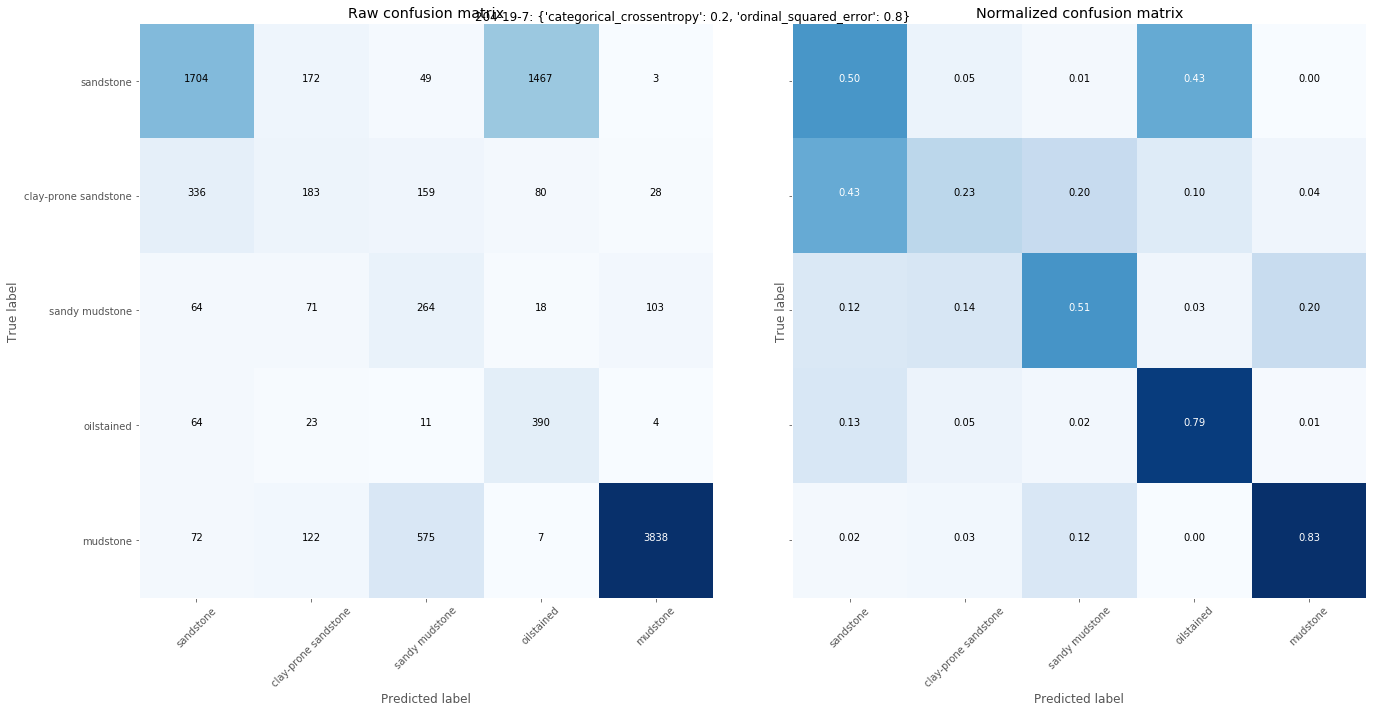



TESTING WITH TEST WELL: 204-20-1


Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:79: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('pseudoGR', (9807, 32, 8))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('pseudoGR', (1917, 32, 8))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (2940,)), ('top', (2940,)), ('base', (2940,)), ('pseudoGR', (2940, 32, 8))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (10906,)), ('top', (10

/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:79: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('pseudoGR', (11210, 32, 8))]

MODELING WITH LOSS: categorical_crossentropy

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_198 (Conv1D)             (None, 4096, 64)     3648        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_199 (Conv1D)             (None, 4096, 128)    24704       conv1d_198[0][0]                 
__________________________________________________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
47/47 [==============================] - 34s 718ms/step - loss: 1.7113 - acc: 0.3939 - val_loss: 0.7518 - val_acc: 0.6801
Epoch 2/15
47/47 [==============================] - 19s 399ms/step - loss: 0.8595 - acc: 0.5842 - val_loss: 0.4800 - val_acc: 0.8609
Epoch 3/15
47/47 [==============================] - 19s 398ms/step - loss: 0.7139 - acc: 0.6541 - val_loss: 0.8233 - val_acc: 0.5589
Epoch 4/15
47/47 [==============================] - 19s 406ms/step - loss: 0.6709 - acc: 0.6844 - val_loss: 0.8012 - val_acc: 0.6010
Epoch 5/15
47/47 [==============================] - 20s 418ms/step - loss: 0.6277 - acc: 0.7012 - val_loss: 0.8888 - val_acc: 0.5834
Epoch 6/15
47/47 [==============================] - 20s 419ms/step - loss: 0.5933 - acc: 0.7174 - val_loss: 0.7200 - val_acc: 0.7130
Epoch 7/15
47/47 [==============================] - 20s 421ms/step - loss: 0.5875 - acc: 0.7092 - val_loss: 1.5508 - val_acc: 0.5388
Epoch 8/1

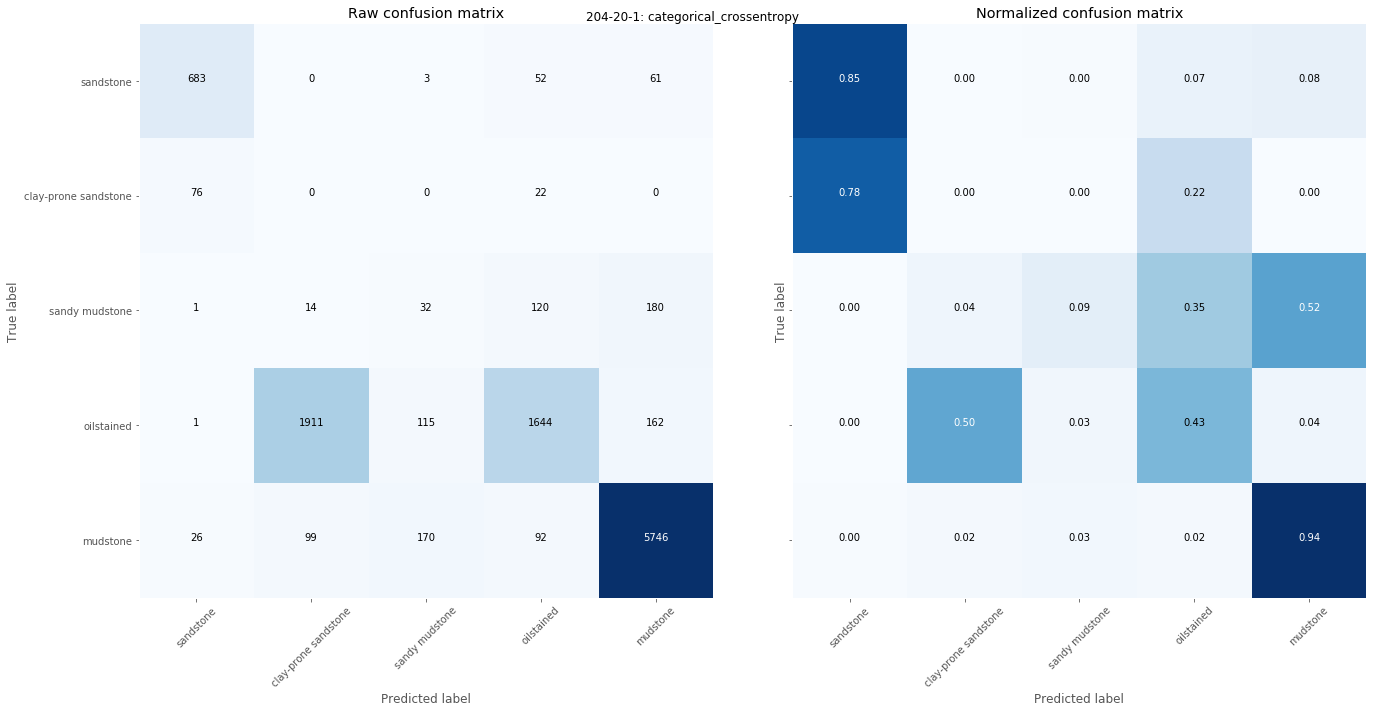


MODELING WITH LOSS: ordinal_squared_error

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_264 (Conv1D)             (None, 4096, 64)     3648        input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_265 (Conv1D)             (None, 4096, 128)    24704       conv1d_264[0][0]                 
__________________________________________________________________________________________________
conv1d_266 (Conv1D)             (None, 4096, 128)    24704       conv1d_264[0][0]                 
_________________________________________________________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
47/47 [==============================] - 34s 714ms/step - loss: 1.6687 - acc: 0.4170 - val_loss: 0.5268 - val_acc: 0.7717
Epoch 2/15
47/47 [==============================] - 20s 421ms/step - loss: 0.8198 - acc: 0.6141 - val_loss: 0.5251 - val_acc: 0.7371
Epoch 3/15
47/47 [==============================] - 20s 423ms/step - loss: 0.6899 - acc: 0.6583 - val_loss: 0.5494 - val_acc: 0.7798
Epoch 4/15
47/47 [==============================] - 20s 421ms/step - loss: 0.6878 - acc: 0.6690 - val_loss: 0.8174 - val_acc: 0.5783
Epoch 5/15
47/47 [==============================] - 20s 422ms/step - loss: 0.6336 - acc: 0.7015 - val_loss: 1.1910 - val_acc: 0.5686
Epoch 6/15
47/47 [==============================] - 20s 419ms/step - loss: 0.6089 - acc: 0.7065 - val_loss: 1.3420 - val_acc: 0.4474
Epoch 7/15
47/47 [==============================] - 20s 421ms/step - loss: 0.5970 - acc: 0.7106 - val_loss: 0.6347 - val_acc: 0.7140
Epoch 8/1

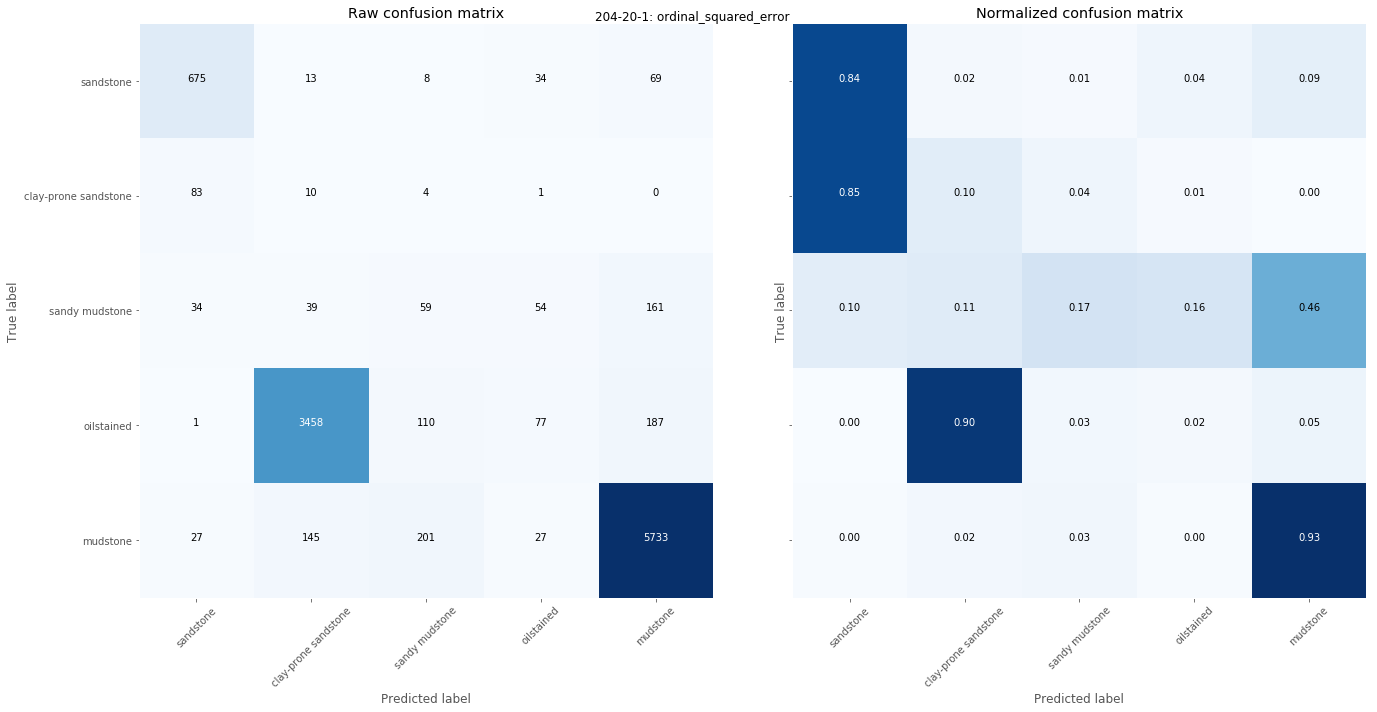


MODELING WITH LOSS: {'categorical_crossentropy': 0.2, 'ordinal_squared_error': 0.8}

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_330 (Conv1D)             (None, 4096, 64)     3648        input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_331 (Conv1D)             (None, 4096, 128)    24704       conv1d_330[0][0]                 
__________________________________________________________________________________________________
conv1d_332 (Conv1D)             (None, 4096, 128)    24704       conv1d_330[0][0]                 
_______________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
47/47 [==============================] - 35s 735ms/step - loss: 1.5015 - acc: 0.3280 - val_loss: 0.6356 - val_acc: 0.6789
Epoch 2/15
47/47 [==============================] - 20s 424ms/step - loss: 0.8530 - acc: 0.5926 - val_loss: 0.5711 - val_acc: 0.6418
Epoch 3/15
47/47 [==============================] - 20s 424ms/step - loss: 0.7058 - acc: 0.6623 - val_loss: 0.9505 - val_acc: 0.5774
Epoch 4/15
47/47 [==============================] - 20s 421ms/step - loss: 0.6647 - acc: 0.6725 - val_loss: 0.8372 - val_acc: 0.5865
Epoch 5/15
47/47 [==============================] - 20s 422ms/step - loss: 0.6351 - acc: 0.6975 - val_loss: 0.7680 - val_acc: 0.6007
Epoch 6/15
47/47 [==============================] - 20s 421ms/step - loss: 0.6079 - acc: 0.7074 - val_loss: 0.7960 - val_acc: 0.6166
Epoch 7/15
47/47 [==============================] - 20s 423ms/step - loss: 0.6152 - acc: 0.6948 - val_loss: 0.7412 - val_acc: 0.6184
Epoch 8/1

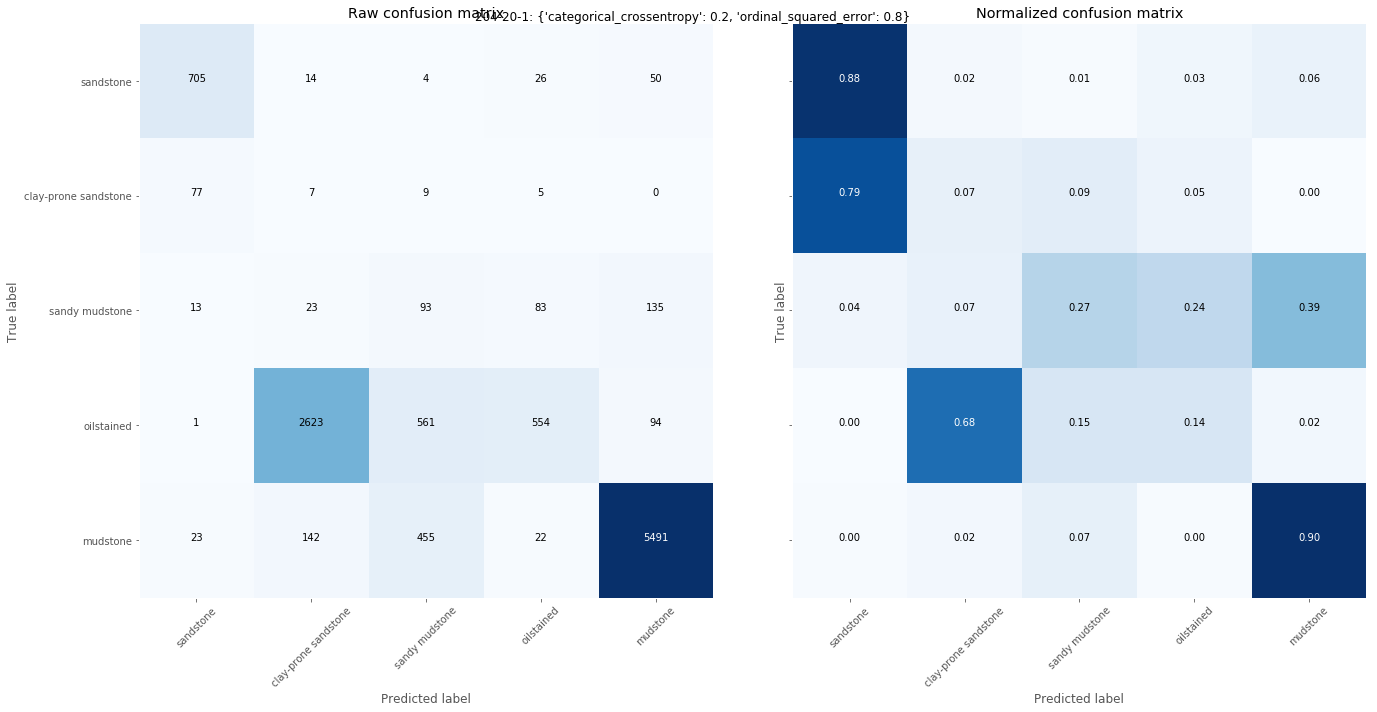



TESTING WITH TEST WELL: 204-20-1Z


Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:79: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('pseudoGR', (9807, 32, 8))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('pseudoGR', (11210, 32, 8))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (2940,)), ('top', (2940,)), ('base', (2940,)), ('pseudoGR', (2940, 32, 8))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (10906,)), ('top', 

/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:79: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('pseudoGR', (1917, 32, 8))]

MODELING WITH LOSS: categorical_crossentropy

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_396 (Conv1D)             (None, 4096, 64)     3648        input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_397 (Conv1D)             (None, 4096, 128)    24704       conv1d_396[0][0]                 
______________________________________________________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
56/56 [==============================] - 36s 651ms/step - loss: 3.2558 - acc: 0.3777 - val_loss: 1.1298 - val_acc: 0.7316
Epoch 2/15
56/56 [==============================] - 20s 364ms/step - loss: 0.7984 - acc: 0.6332 - val_loss: 0.8934 - val_acc: 0.7118
Epoch 3/15
56/56 [==============================] - 20s 364ms/step - loss: 0.6603 - acc: 0.6748 - val_loss: 0.9760 - val_acc: 0.7196
Epoch 4/15
56/56 [==============================] - 21s 374ms/step - loss: 0.6430 - acc: 0.6918 - val_loss: 1.0368 - val_acc: 0.7196
Epoch 5/15
56/56 [==============================] - 21s 380ms/step - loss: 0.6073 - acc: 0.7096 - val_loss: 0.7353 - val_acc: 0.7352
Epoch 6/15
56/56 [==============================] - 21s 380ms/step - loss: 0.6053 - acc: 0.7054 - val_loss: 0.9679 - val_acc: 0.7157
Epoch 7/15
56/56 [==============================] - 21s 379ms/step - loss: 0.6045 - acc: 0.7090 - val_loss: 0.8491 - val_acc: 0.7405
Epoch 8/1

/home/administrator/code/python/coremdlr/coremdlr/viz/model_plots.py:50: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


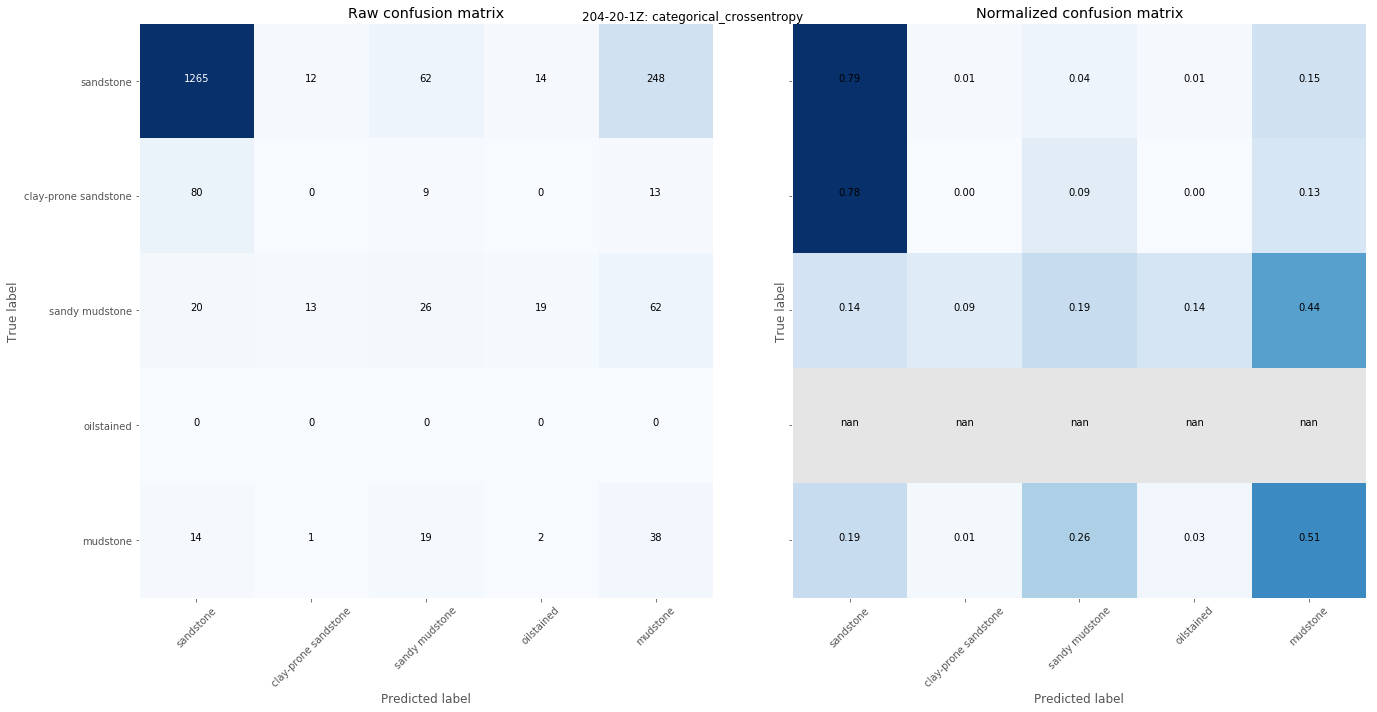


MODELING WITH LOSS: ordinal_squared_error

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_462 (Conv1D)             (None, 4096, 64)     3648        input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_463 (Conv1D)             (None, 4096, 128)    24704       conv1d_462[0][0]                 
__________________________________________________________________________________________________
conv1d_464 (Conv1D)             (None, 4096, 128)    24704       conv1d_462[0][0]                 
_________________________________________________________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
56/56 [==============================] - 38s 671ms/step - loss: 1.5175 - acc: 0.3599 - val_loss: 0.5934 - val_acc: 0.7612
Epoch 2/15
56/56 [==============================] - 21s 374ms/step - loss: 0.8269 - acc: 0.6218 - val_loss: 0.7960 - val_acc: 0.7539
Epoch 3/15
56/56 [==============================] - 21s 374ms/step - loss: 0.6904 - acc: 0.6568 - val_loss: 1.2054 - val_acc: 0.6345
Epoch 4/15
56/56 [==============================] - 21s 375ms/step - loss: 0.6671 - acc: 0.6570 - val_loss: 0.9400 - val_acc: 0.6861
Epoch 5/15
56/56 [==============================] - 21s 374ms/step - loss: 0.6137 - acc: 0.7015 - val_loss: 0.8469 - val_acc: 0.7042
Epoch 6/15
56/56 [==============================] - 21s 374ms/step - loss: 0.6130 - acc: 0.7054 - val_loss: 0.8581 - val_acc: 0.7402
Epoch 7/15
56/56 [==============================] - 21s 374ms/step - loss: 0.6150 - acc: 0.6998 - val_loss: 0.8338 - val_acc: 0.7107
Epoch 8/1

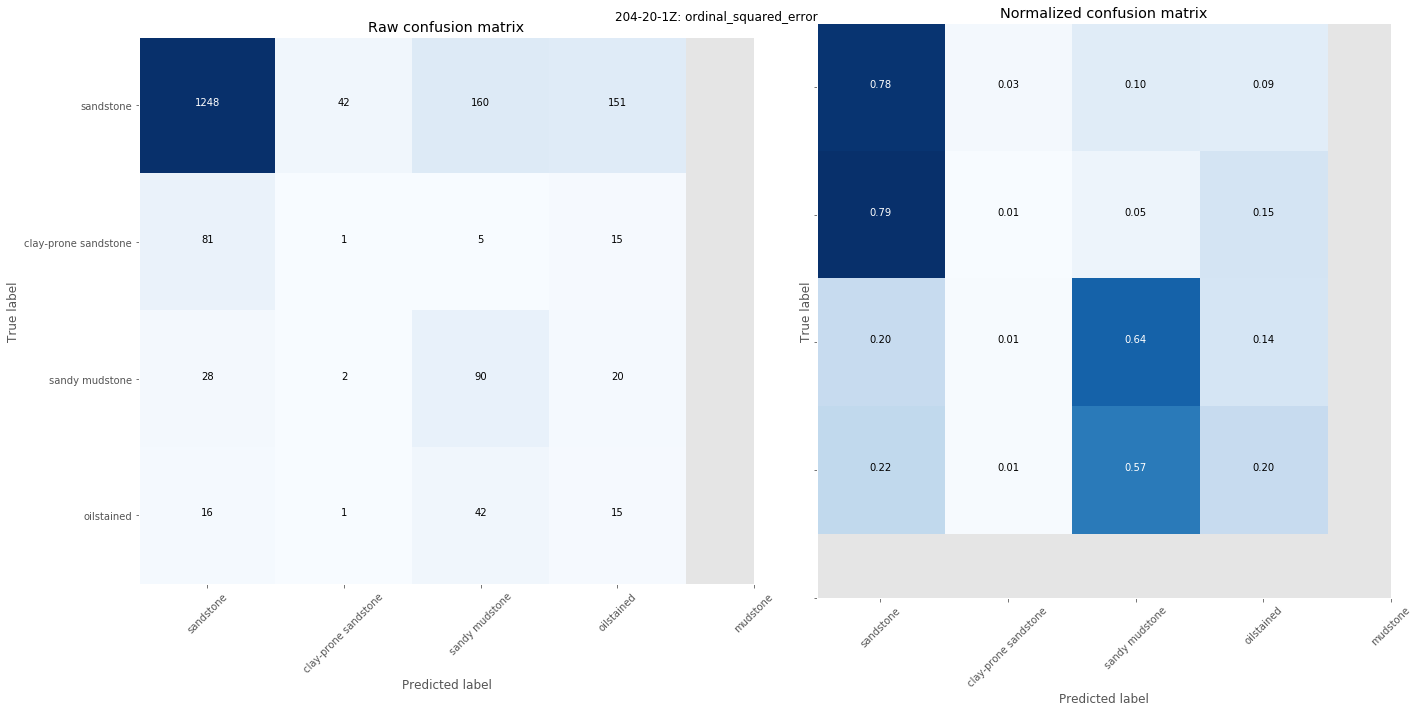


MODELING WITH LOSS: {'categorical_crossentropy': 0.2, 'ordinal_squared_error': 0.8}

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_528 (Conv1D)             (None, 4096, 64)     3648        input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_529 (Conv1D)             (None, 4096, 128)    24704       conv1d_528[0][0]                 
__________________________________________________________________________________________________
conv1d_530 (Conv1D)             (None, 4096, 128)    24704       conv1d_528[0][0]                 
_______________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
56/56 [==============================] - 38s 679ms/step - loss: 6.2854 - acc: 0.3215 - val_loss: 8.9104 - val_acc: 0.0413
Epoch 2/15
56/56 [==============================] - 21s 373ms/step - loss: 6.2836 - acc: 0.3296 - val_loss: 8.9104 - val_acc: 0.0413
Epoch 3/15
56/56 [==============================] - 21s 375ms/step - loss: 6.2817 - acc: 0.3298 - val_loss: 8.9104 - val_acc: 0.0413
Epoch 4/15
56/56 [==============================] - 21s 375ms/step - loss: 6.2846 - acc: 0.3296 - val_loss: 8.9104 - val_acc: 0.0413
Epoch 5/15
56/56 [==============================] - 21s 375ms/step - loss: 6.2827 - acc: 0.3297 - val_loss: 8.9104 - val_acc: 0.0413
Epoch 6/15
56/56 [==============================] - 21s 375ms/step - loss: 6.2829 - acc: 0.3297 - val_loss: 8.9104 - val_acc: 0.0413
Epoch 7/15
56/56 [==============================] - 21s 379ms/step - loss: 6.2814 - acc: 0.3299 - val_loss: 8.9104 - val_acc: 0.0413
Epoch 8/1

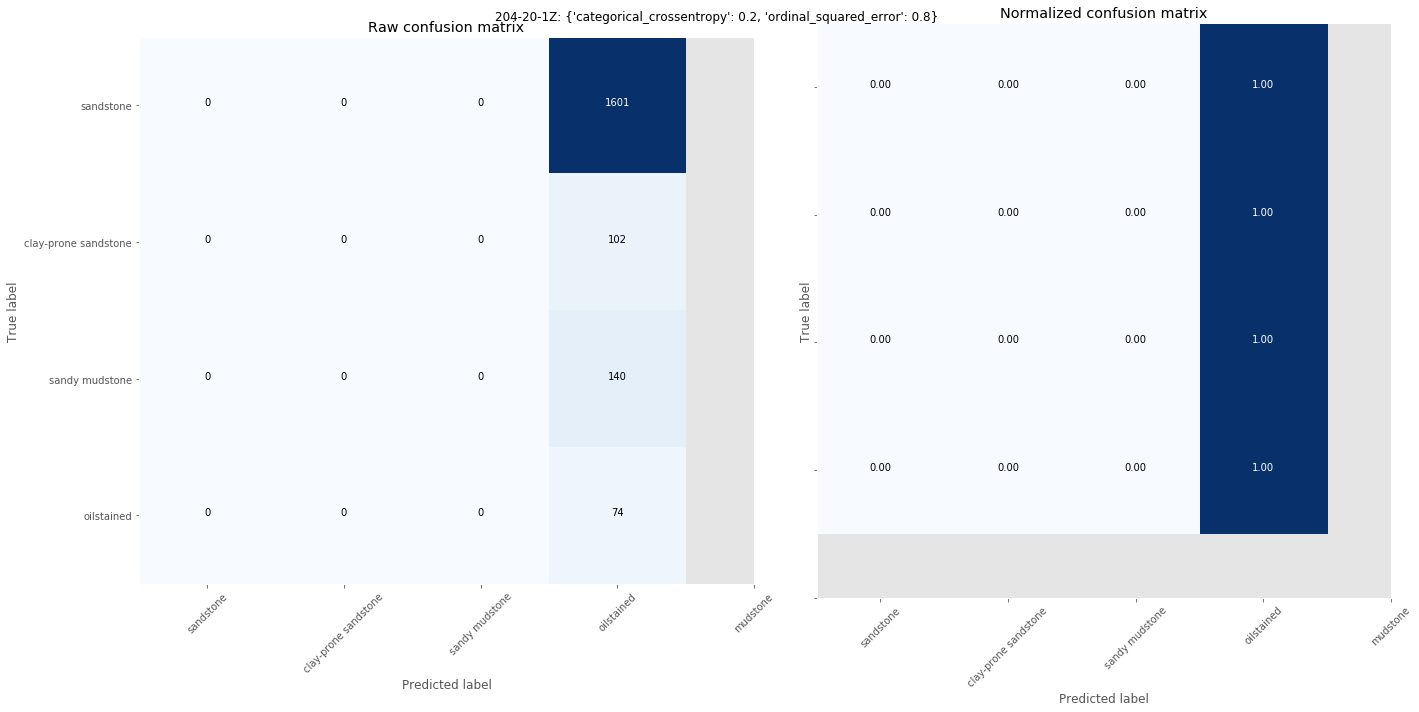



TESTING WITH TEST WELL: 204-20-2


Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:79: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('pseudoGR', (9807, 32, 8))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('pseudoGR', (11210, 32, 8))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('pseudoGR', (1917, 32, 8))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (10906,)), ('top',

/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:79: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (2940,)), ('top', (2940,)), ('base', (2940,)), ('pseudoGR', (2940, 32, 8))]

MODELING WITH LOSS: categorical_crossentropy

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_594 (Conv1D)             (None, 4096, 64)     3648        input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_595 (Conv1D)             (None, 4096, 128)    24704       conv1d_594[0][0]                 
______________________________________________________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
55/55 [==============================] - 39s 715ms/step - loss: 2.7411 - acc: 0.3403 - val_loss: 2.9967 - val_acc: 0.0112
Epoch 2/15
55/55 [==============================] - 21s 373ms/step - loss: 0.7906 - acc: 0.6490 - val_loss: 1.8802 - val_acc: 0.0325
Epoch 3/15
55/55 [==============================] - 21s 373ms/step - loss: 0.6665 - acc: 0.6961 - val_loss: 2.2019 - val_acc: 0.0430
Epoch 4/15
55/55 [==============================] - 21s 382ms/step - loss: 0.6321 - acc: 0.7078 - val_loss: 1.9811 - val_acc: 0.0357
Epoch 5/15
55/55 [==============================] - 21s 387ms/step - loss: 0.6245 - acc: 0.7068 - val_loss: 1.5204 - val_acc: 0.1483
Epoch 6/15
55/55 [==============================] - 21s 390ms/step - loss: 0.6270 - acc: 0.7071 - val_loss: 2.2368 - val_acc: 0.0490
Epoch 7/15
55/55 [==============================] - 21s 389ms/step - loss: 0.6128 - acc: 0.7102 - val_loss: 1.3892 - val_acc: 0.0724
Epoch 8/1

/home/administrator/code/python/coremdlr/coremdlr/viz/model_plots.py:50: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


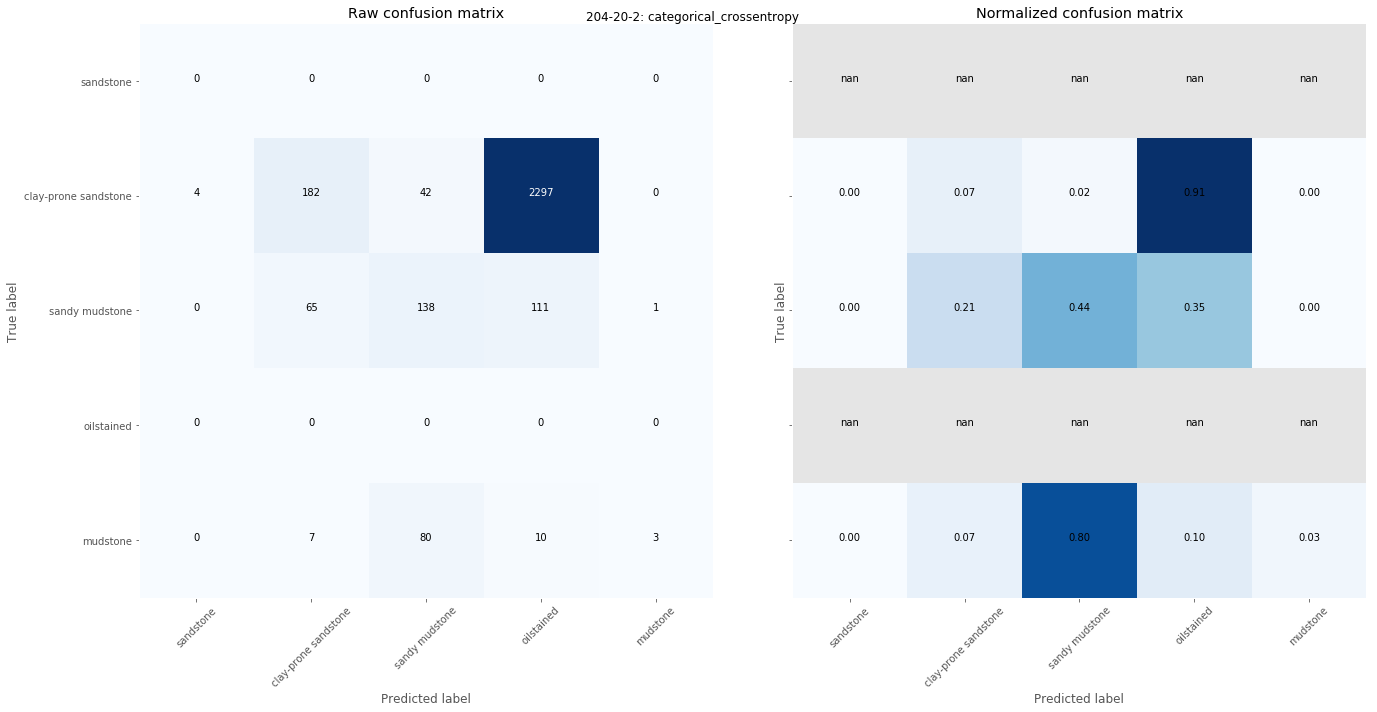


MODELING WITH LOSS: ordinal_squared_error

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_660 (Conv1D)             (None, 4096, 64)     3648        input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_661 (Conv1D)             (None, 4096, 128)    24704       conv1d_660[0][0]                 
__________________________________________________________________________________________________
conv1d_662 (Conv1D)             (None, 4096, 128)    24704       conv1d_660[0][0]                 
_________________________________________________________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
55/55 [==============================] - 41s 750ms/step - loss: 2.5342 - acc: 0.3741 - val_loss: 2.0085 - val_acc: 0.0231
Epoch 2/15
55/55 [==============================] - 22s 391ms/step - loss: 0.7584 - acc: 0.6791 - val_loss: 1.7312 - val_acc: 0.0320
Epoch 3/15
55/55 [==============================] - 22s 392ms/step - loss: 0.6585 - acc: 0.7059 - val_loss: 1.5973 - val_acc: 0.0543
Epoch 4/15
55/55 [==============================] - 22s 393ms/step - loss: 0.6066 - acc: 0.7160 - val_loss: 1.7010 - val_acc: 0.0950
Epoch 5/15
55/55 [==============================] - 21s 389ms/step - loss: 0.5889 - acc: 0.7266 - val_loss: 1.4631 - val_acc: 0.0927
Epoch 6/15
55/55 [==============================] - 21s 390ms/step - loss: 0.5843 - acc: 0.7305 - val_loss: 1.9265 - val_acc: 0.0575
Epoch 7/15
55/55 [==============================] - 21s 388ms/step - loss: 0.5818 - acc: 0.7280 - val_loss: 1.7426 - val_acc: 0.0936
Epoch 8/1

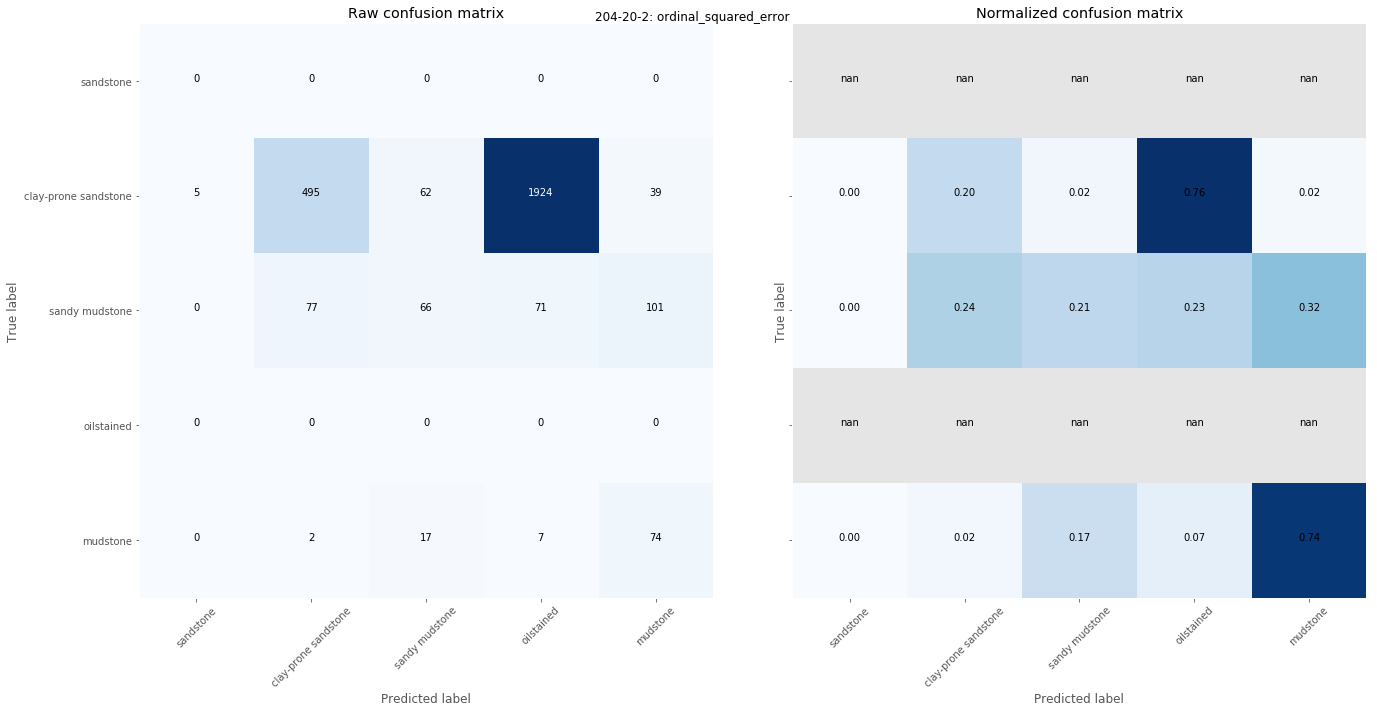


MODELING WITH LOSS: {'categorical_crossentropy': 0.2, 'ordinal_squared_error': 0.8}

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_726 (Conv1D)             (None, 4096, 64)     3648        input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_727 (Conv1D)             (None, 4096, 128)    24704       conv1d_726[0][0]                 
__________________________________________________________________________________________________
conv1d_728 (Conv1D)             (None, 4096, 128)    24704       conv1d_726[0][0]                 
_______________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
55/55 [==============================] - 44s 799ms/step - loss: 1.4651 - acc: 0.3667 - val_loss: 4.1311 - val_acc: 0.0265
Epoch 2/15
55/55 [==============================] - 21s 381ms/step - loss: 0.8371 - acc: 0.6476 - val_loss: 1.5975 - val_acc: 0.0371
Epoch 3/15
55/55 [==============================] - 21s 383ms/step - loss: 0.6608 - acc: 0.6939 - val_loss: 2.4979 - val_acc: 0.0405
Epoch 4/15
55/55 [==============================] - 21s 386ms/step - loss: 0.6410 - acc: 0.6925 - val_loss: 1.6732 - val_acc: 0.0527
Epoch 5/15
55/55 [==============================] - 21s 387ms/step - loss: 0.6268 - acc: 0.7075 - val_loss: 1.4870 - val_acc: 0.0774
Epoch 6/15
55/55 [==============================] - 21s 386ms/step - loss: 0.6080 - acc: 0.7181 - val_loss: 1.8251 - val_acc: 0.1151
Epoch 7/15
55/55 [==============================] - 21s 388ms/step - loss: 0.5864 - acc: 0.7292 - val_loss: 2.0761 - val_acc: 0.1019
Epoch 8/1

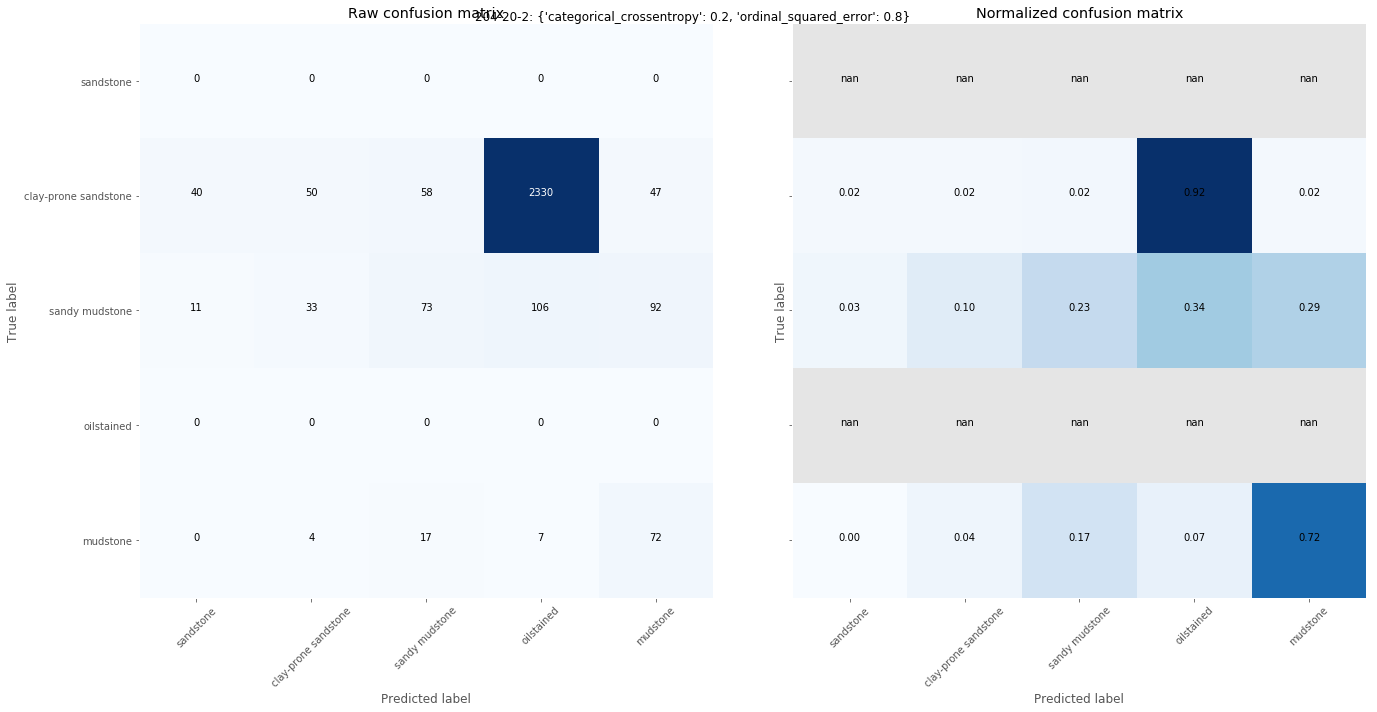



TESTING WITH TEST WELL: 204-20-3


Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:79: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('pseudoGR', (9807, 32, 8))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('pseudoGR', (11210, 32, 8))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('pseudoGR', (1917, 32, 8))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (2940,)), ('top', 

/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:79: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (10906,)), ('top', (10906,)), ('base', (10906,)), ('pseudoGR', (10906, 32, 8))]

MODELING WITH LOSS: categorical_crossentropy

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_792 (Conv1D)             (None, 4096, 64)     3648        input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_793 (Conv1D)             (None, 4096, 128)    24704       conv1d_792[0][0]                 
__________________________________________________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
48/48 [==============================] - 44s 925ms/step - loss: 1.4405 - acc: 0.3643 - val_loss: 1.2142 - val_acc: 0.5797
Epoch 2/15
48/48 [==============================] - 20s 422ms/step - loss: 0.7818 - acc: 0.6383 - val_loss: 0.8599 - val_acc: 0.5876
Epoch 3/15
48/48 [==============================] - 20s 423ms/step - loss: 0.6744 - acc: 0.6676 - val_loss: 0.6932 - val_acc: 0.6727
Epoch 4/15
48/48 [==============================] - 21s 431ms/step - loss: 0.6695 - acc: 0.6725 - val_loss: 1.1092 - val_acc: 0.6415
Epoch 5/15
48/48 [==============================] - 21s 439ms/step - loss: 0.6214 - acc: 0.6921 - val_loss: 0.7622 - val_acc: 0.5600
Epoch 6/15
48/48 [==============================] - 21s 443ms/step - loss: 0.6102 - acc: 0.7062 - val_loss: 0.7040 - val_acc: 0.7005
Epoch 7/15
48/48 [==============================] - 21s 440ms/step - loss: 0.5848 - acc: 0.7172 - val_loss: 0.8846 - val_acc: 0.5632
Epoch 8/1

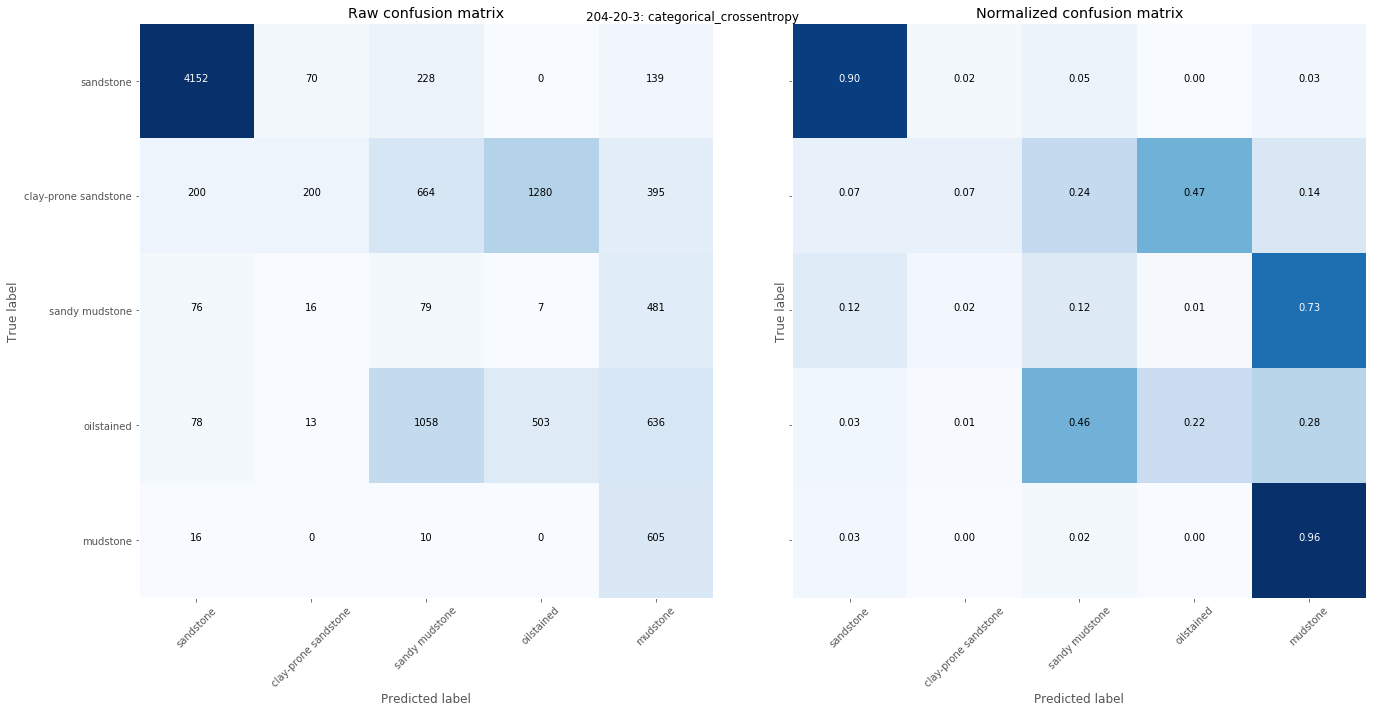


MODELING WITH LOSS: ordinal_squared_error

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_858 (Conv1D)             (None, 4096, 64)     3648        input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_859 (Conv1D)             (None, 4096, 128)    24704       conv1d_858[0][0]                 
__________________________________________________________________________________________________
conv1d_860 (Conv1D)             (None, 4096, 128)    24704       conv1d_858[0][0]                 
_________________________________________________________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
48/48 [==============================] - 45s 939ms/step - loss: 5.8993 - acc: 0.3446 - val_loss: 9.0039 - val_acc: 0.0583
Epoch 2/15
48/48 [==============================] - 22s 458ms/step - loss: 1.7348 - acc: 0.5343 - val_loss: 0.6512 - val_acc: 0.7042
Epoch 3/15
48/48 [==============================] - 21s 447ms/step - loss: 0.6907 - acc: 0.6679 - val_loss: 0.7288 - val_acc: 0.5841
Epoch 4/15
48/48 [==============================] - 22s 454ms/step - loss: 0.6579 - acc: 0.6841 - val_loss: 0.8281 - val_acc: 0.5394
Epoch 5/15
48/48 [==============================] - 22s 452ms/step - loss: 0.6540 - acc: 0.6885 - val_loss: 0.9425 - val_acc: 0.5515
Epoch 6/15
48/48 [==============================] - 22s 460ms/step - loss: 0.5917 - acc: 0.7159 - val_loss: 0.8352 - val_acc: 0.5761
Epoch 7/15
48/48 [==============================] - 21s 443ms/step - loss: 0.5855 - acc: 0.7176 - val_loss: 0.9781 - val_acc: 0.5576
Epoch 8/1

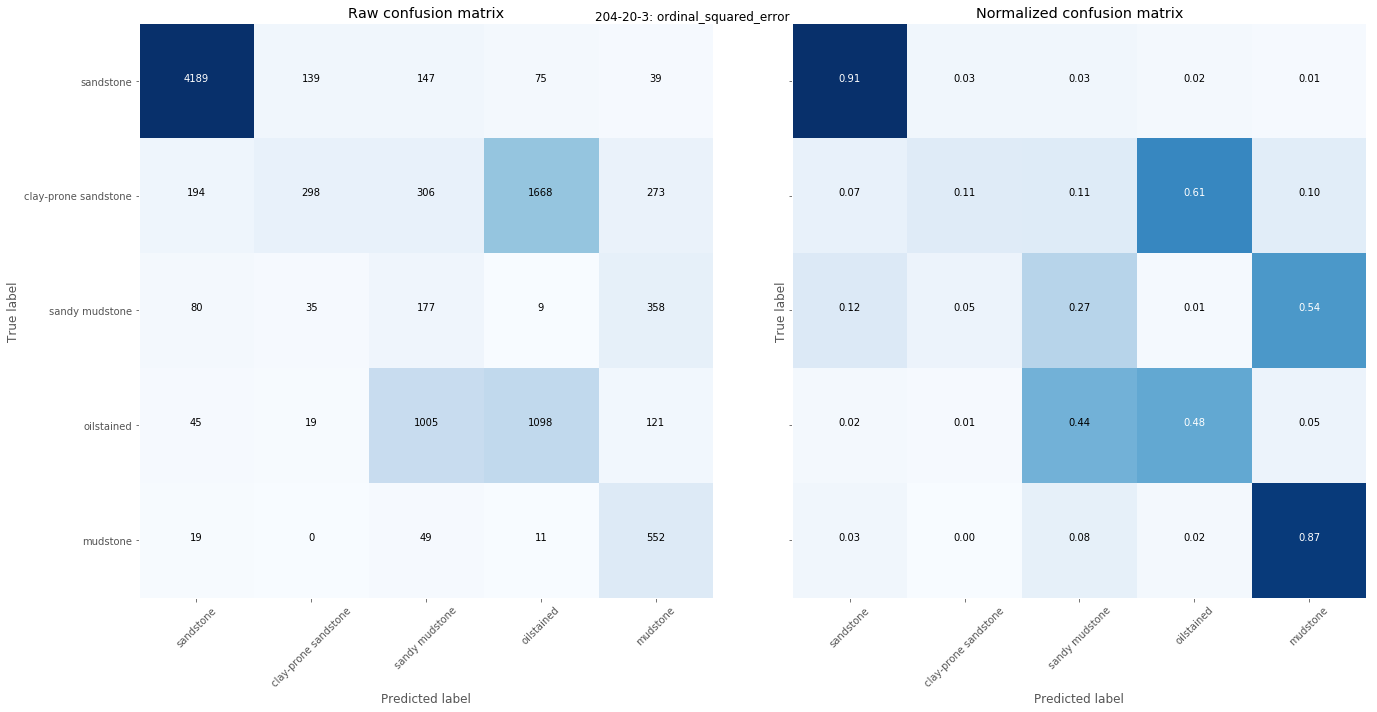


MODELING WITH LOSS: {'categorical_crossentropy': 0.2, 'ordinal_squared_error': 0.8}

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_924 (Conv1D)             (None, 4096, 64)     3648        input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_925 (Conv1D)             (None, 4096, 128)    24704       conv1d_924[0][0]                 
__________________________________________________________________________________________________
conv1d_926 (Conv1D)             (None, 4096, 128)    24704       conv1d_924[0][0]                 
_______________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
48/48 [==============================] - 47s 976ms/step - loss: 1.6320 - acc: 0.3033 - val_loss: 1.3707 - val_acc: 0.1972
Epoch 2/15
48/48 [==============================] - 22s 450ms/step - loss: 0.8132 - acc: 0.6177 - val_loss: 1.2280 - val_acc: 0.5125
Epoch 3/15
48/48 [==============================] - 21s 441ms/step - loss: 0.6983 - acc: 0.6611 - val_loss: 0.7079 - val_acc: 0.6218
Epoch 4/15
48/48 [==============================] - 21s 439ms/step - loss: 0.6583 - acc: 0.6722 - val_loss: 0.7444 - val_acc: 0.6287
Epoch 5/15
48/48 [==============================] - 22s 453ms/step - loss: 0.6271 - acc: 0.6994 - val_loss: 0.6850 - val_acc: 0.6942
Epoch 6/15
48/48 [==============================] - 21s 446ms/step - loss: 0.6230 - acc: 0.7025 - val_loss: 0.8859 - val_acc: 0.6013
Epoch 7/15
48/48 [==============================] - 22s 456ms/step - loss: 0.6239 - acc: 0.6984 - val_loss: 0.8420 - val_acc: 0.6055
Epoch 8/1

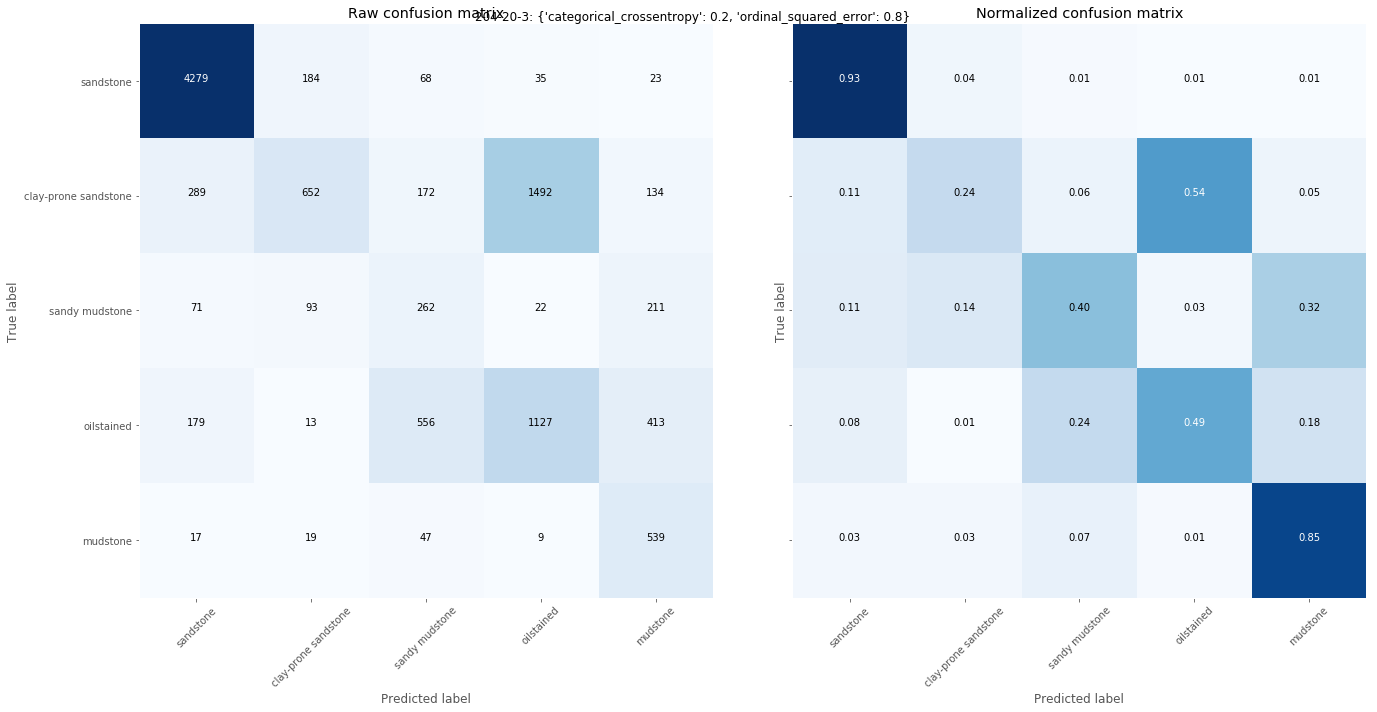



TESTING WITH TEST WELL: 205-21b-3


Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:79: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('pseudoGR', (9807, 32, 8))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('pseudoGR', (11210, 32, 8))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('pseudoGR', (1917, 32, 8))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (2940,)), ('top', 

/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:79: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('pseudoGR', (3842, 32, 8))]

MODELING WITH LOSS: categorical_crossentropy

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_990 (Conv1D)             (None, 4096, 64)     3648        input_16[0][0]                   
__________________________________________________________________________________________________
conv1d_991 (Conv1D)             (None, 4096, 128)    24704       conv1d_990[0][0]                 
______________________________________________________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
55/55 [==============================] - 50s 903ms/step - loss: 1.2883 - acc: 0.4108 - val_loss: 3.6138 - val_acc: 0.0114
Epoch 2/15
55/55 [==============================] - 21s 379ms/step - loss: 0.7076 - acc: 0.6786 - val_loss: 1.6145 - val_acc: 0.2369
Epoch 3/15
55/55 [==============================] - 21s 380ms/step - loss: 0.5961 - acc: 0.7073 - val_loss: 2.2486 - val_acc: 0.0693
Epoch 4/15
55/55 [==============================] - 21s 389ms/step - loss: 0.5910 - acc: 0.7014 - val_loss: 1.7816 - val_acc: 0.0432
Epoch 5/15
55/55 [==============================] - 23s 412ms/step - loss: 0.5833 - acc: 0.7235 - val_loss: 2.3414 - val_acc: 0.0708
Epoch 6/15
55/55 [==============================] - 23s 412ms/step - loss: 0.5473 - acc: 0.7448 - val_loss: 1.9400 - val_acc: 0.1483
Epoch 7/15
55/55 [==============================] - 22s 396ms/step - loss: 0.5269 - acc: 0.7496 - val_loss: 2.5927 - val_acc: 0.0703
Epoch 8/1

/home/administrator/code/python/coremdlr/coremdlr/viz/model_plots.py:50: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


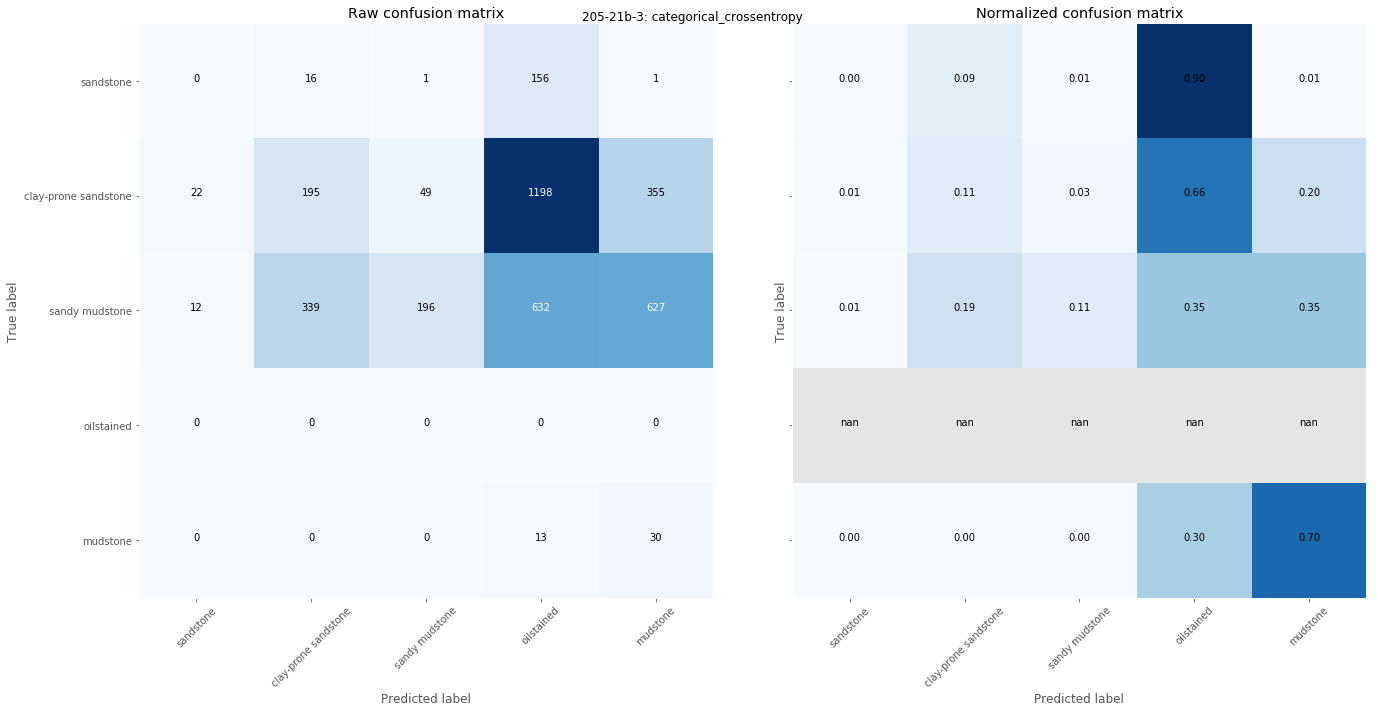


MODELING WITH LOSS: ordinal_squared_error

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_1056 (Conv1D)            (None, 4096, 64)     3648        input_17[0][0]                   
__________________________________________________________________________________________________
conv1d_1057 (Conv1D)            (None, 4096, 128)    24704       conv1d_1056[0][0]                
__________________________________________________________________________________________________
conv1d_1058 (Conv1D)            (None, 4096, 128)    24704       conv1d_1056[0][0]                
_________________________________________________________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
55/55 [==============================] - 50s 906ms/step - loss: 6.0444 - acc: 0.3374 - val_loss: 10.2216 - val_acc: 0.0114
Epoch 2/15
55/55 [==============================] - 23s 410ms/step - loss: 6.0260 - acc: 0.3471 - val_loss: 10.2216 - val_acc: 0.0114
Epoch 3/15
55/55 [==============================] - 23s 413ms/step - loss: 6.0024 - acc: 0.3489 - val_loss: 10.2216 - val_acc: 0.0114
Epoch 4/15
55/55 [==============================] - 22s 400ms/step - loss: 6.1160 - acc: 0.3359 - val_loss: 10.2216 - val_acc: 0.0114
Epoch 5/15
55/55 [==============================] - 22s 398ms/step - loss: 6.1160 - acc: 0.3359 - val_loss: 10.2216 - val_acc: 0.0114
Epoch 6/15
55/55 [==============================] - 23s 413ms/step - loss: 6.1170 - acc: 0.3359 - val_loss: 10.2216 - val_acc: 0.0114
Epoch 7/15
55/55 [==============================] - 23s 413ms/step - loss: 5.9861 - acc: 0.3511 - val_loss: 10.2216 - val_acc: 0.0114
Ep

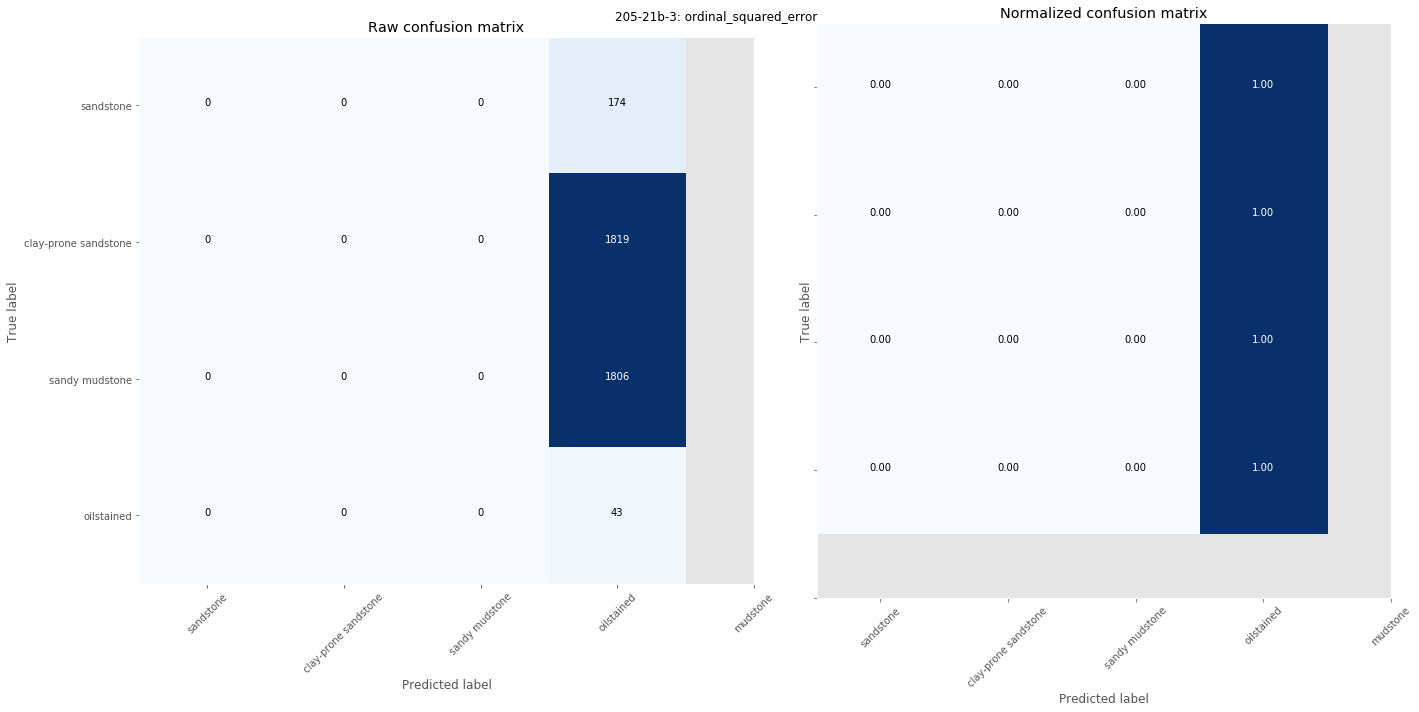


MODELING WITH LOSS: {'categorical_crossentropy': 0.2, 'ordinal_squared_error': 0.8}

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_1122 (Conv1D)            (None, 4096, 64)     3648        input_18[0][0]                   
__________________________________________________________________________________________________
conv1d_1123 (Conv1D)            (None, 4096, 128)    24704       conv1d_1122[0][0]                
__________________________________________________________________________________________________
conv1d_1124 (Conv1D)            (None, 4096, 128)    24704       conv1d_1122[0][0]                
_______________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
55/55 [==============================] - 62s 1s/step - loss: 6.0209 - acc: 0.3389 - val_loss: 10.2216 - val_acc: 0.0114
Epoch 2/15
55/55 [==============================] - 22s 399ms/step - loss: 6.1378 - acc: 0.3359 - val_loss: 10.2216 - val_acc: 0.0114
Epoch 3/15
55/55 [==============================] - 22s 402ms/step - loss: 5.9691 - acc: 0.3527 - val_loss: 10.2216 - val_acc: 0.0114
Epoch 4/15
55/55 [==============================] - 22s 399ms/step - loss: 5.9691 - acc: 0.3527 - val_loss: 10.2216 - val_acc: 0.0114
Epoch 5/15
55/55 [==============================] - 22s 404ms/step - loss: 6.1032 - acc: 0.3403 - val_loss: 10.2216 - val_acc: 0.0114
Epoch 6/15
55/55 [==============================] - 22s 403ms/step - loss: 6.1276 - acc: 0.3371 - val_loss: 10.2216 - val_acc: 0.0114
Epoch 7/15
55/55 [==============================] - 22s 402ms/step - loss: 5.9834 - acc: 0.3512 - val_loss: 10.2216 - val_acc: 0.0114
Epoch

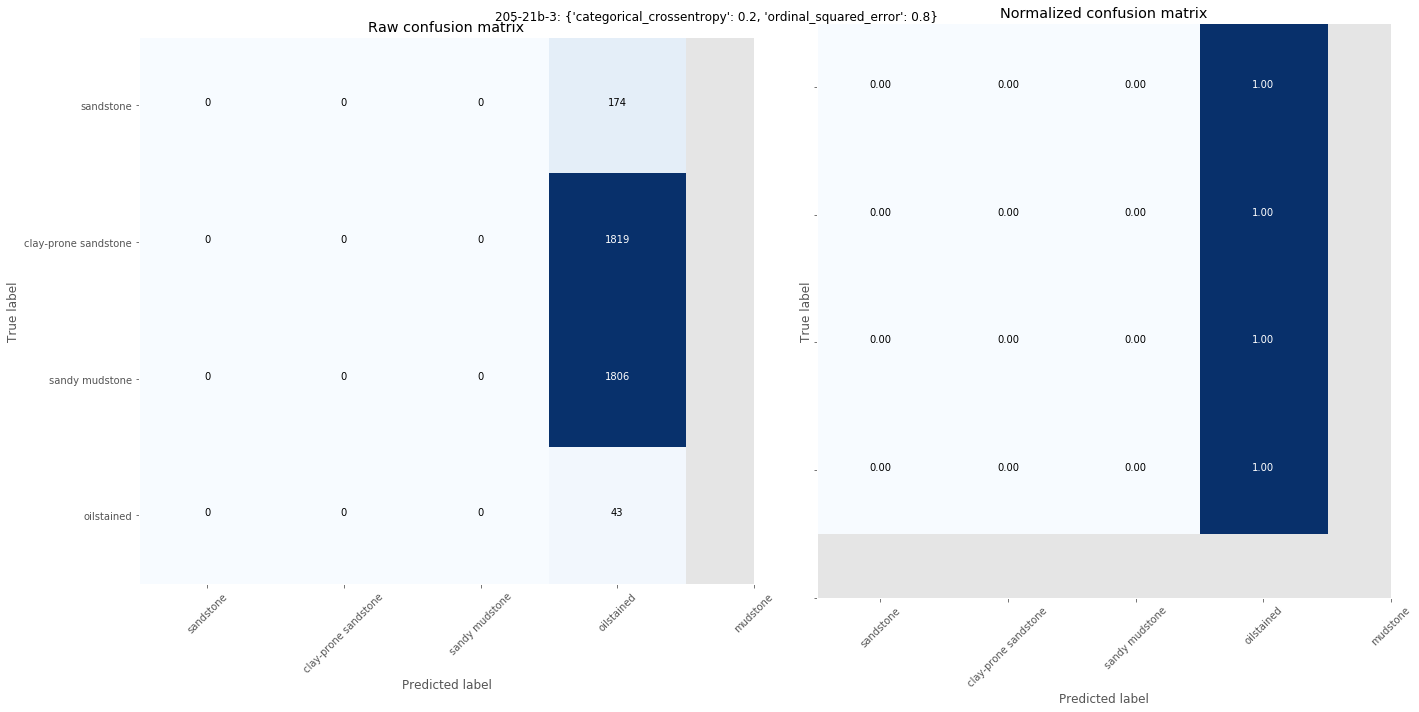



TESTING WITH TEST WELL: 204-24a-7


Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:79: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('pseudoGR', (9807, 32, 8))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('pseudoGR', (11210, 32, 8))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('pseudoGR', (1917, 32, 8))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (2940,)), ('top', 

/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:79: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/datasets/utils.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (19294,)), ('top', (19294,)), ('base', (19294,)), ('pseudoGR', (19294, 32, 8))]

MODELING WITH LOSS: categorical_crossentropy

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_1188 (Conv1D)            (None, 4096, 64)     3648        input_19[0][0]                   
__________________________________________________________________________________________________
conv1d_1189 (Conv1D)            (None, 4096, 128)    24704       conv1d_1188[0][0]                
__________________________________________________________

Shapes of `(batch_X, batch_y)`: (16, 4096, 8), (16, 128, 5)
Epoch 1/15
39/39 [==============================] - 62s 2s/step - loss: 1.5959 - acc: 0.3259 - val_loss: 1.2476 - val_acc: 0.1441
Epoch 2/15
39/39 [==============================] - 21s 535ms/step - loss: 0.9369 - acc: 0.5196 - val_loss: 0.8142 - val_acc: 0.4347
Epoch 3/15
39/39 [==============================] - 21s 530ms/step - loss: 0.7336 - acc: 0.6250 - val_loss: 0.8038 - val_acc: 0.5623
Epoch 4/15
39/39 [==============================] - 21s 547ms/step - loss: 0.6852 - acc: 0.6672 - val_loss: 1.0071 - val_acc: 0.4708
Epoch 5/15
39/39 [==============================] - 22s 555ms/step - loss: 0.6562 - acc: 0.6879 - val_loss: 0.9788 - val_acc: 0.4721
Epoch 6/15
39/39 [==============================] - 22s 563ms/step - loss: 0.6230 - acc: 0.7278 - val_loss: 0.8358 - val_acc: 0.5034
Epoch 7/15
39/39 [==============================] - 22s 557ms/step - loss: 0.5962 - acc: 0.7353 - val_loss: 1.0078 - val_acc: 0.5015
Epoch 8/15
3

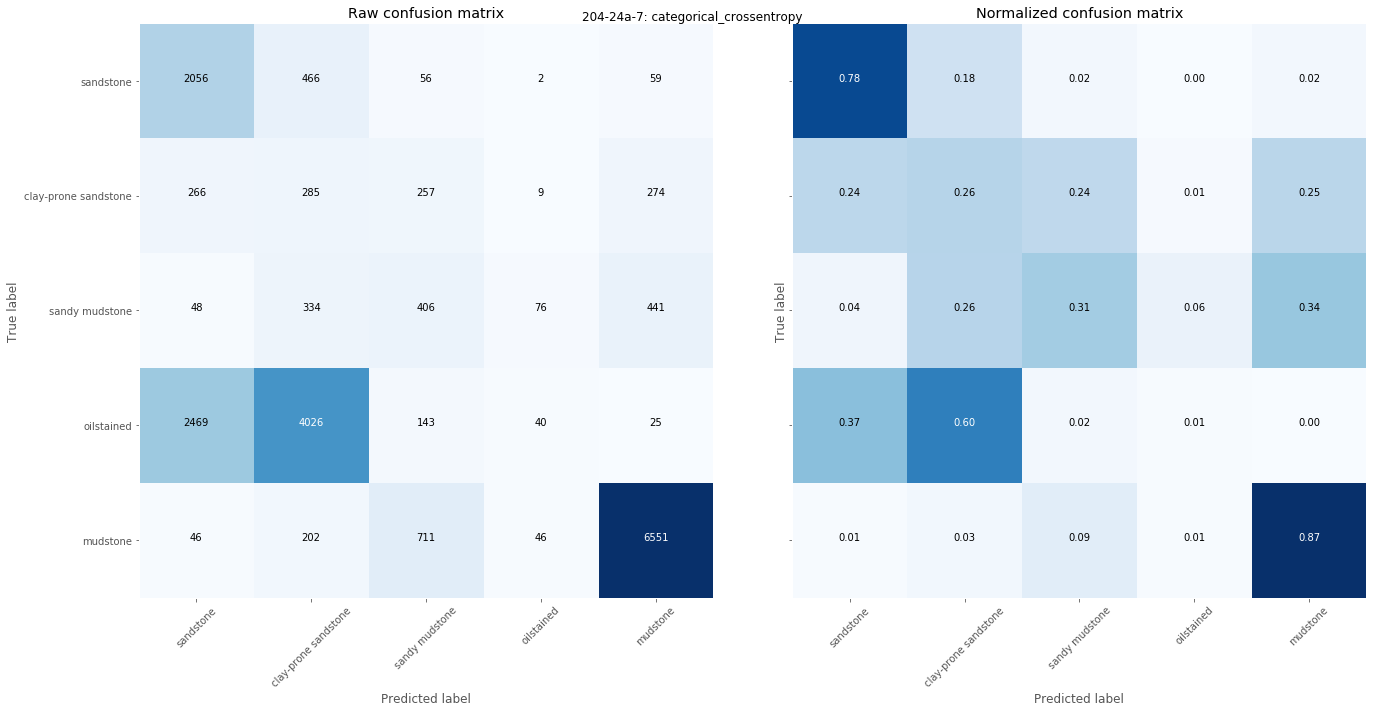


MODELING WITH LOSS: ordinal_squared_error

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_1254 (Conv1D)            (None, 4096, 64)     3648        input_20[0][0]                   
__________________________________________________________________________________________________
conv1d_1255 (Conv1D)            (None, 4096, 128)    24704       conv1d_1254[0][0]                
__________________________________________________________________________________________________
conv1d_1256 (Conv1D)            (None, 4096, 128)    24704       conv1d_1254[0][0]                
_________________________________________________________________

Epoch 1/15
39/39 [==============================] - 56s 1s/step - loss: 1.7460 - acc: 0.3712 - val_loss: 1.4707 - val_acc: 0.1339
Epoch 2/15
39/39 [==============================] - 22s 564ms/step - loss: 0.8689 - acc: 0.5783 - val_loss: 0.8768 - val_acc: 0.4937
Epoch 3/15
39/39 [==============================] - 22s 569ms/step - loss: 0.7176 - acc: 0.6636 - val_loss: 0.8859 - val_acc: 0.5253
Epoch 4/15
39/39 [==============================] - 22s 572ms/step - loss: 0.6474 - acc: 0.7069 - val_loss: 0.8430 - val_acc: 0.5175
Epoch 5/15
39/39 [==============================] - 22s 557ms/step - loss: 0.6006 - acc: 0.7285 - val_loss: 0.9642 - val_acc: 0.4855
Epoch 6/15
39/39 [==============================] - 22s 572ms/step - loss: 0.5621 - acc: 0.7411 - val_loss: 0.7895 - val_acc: 0.5548
Epoch 7/15
39/39 [==============================] - 22s 567ms/step - loss: 0.5481 - acc: 0.7581 - val_loss: 0.9713 - val_acc: 0.4984
Epoch 8/15
39/39 [==============================] - 22s 573ms/step - los

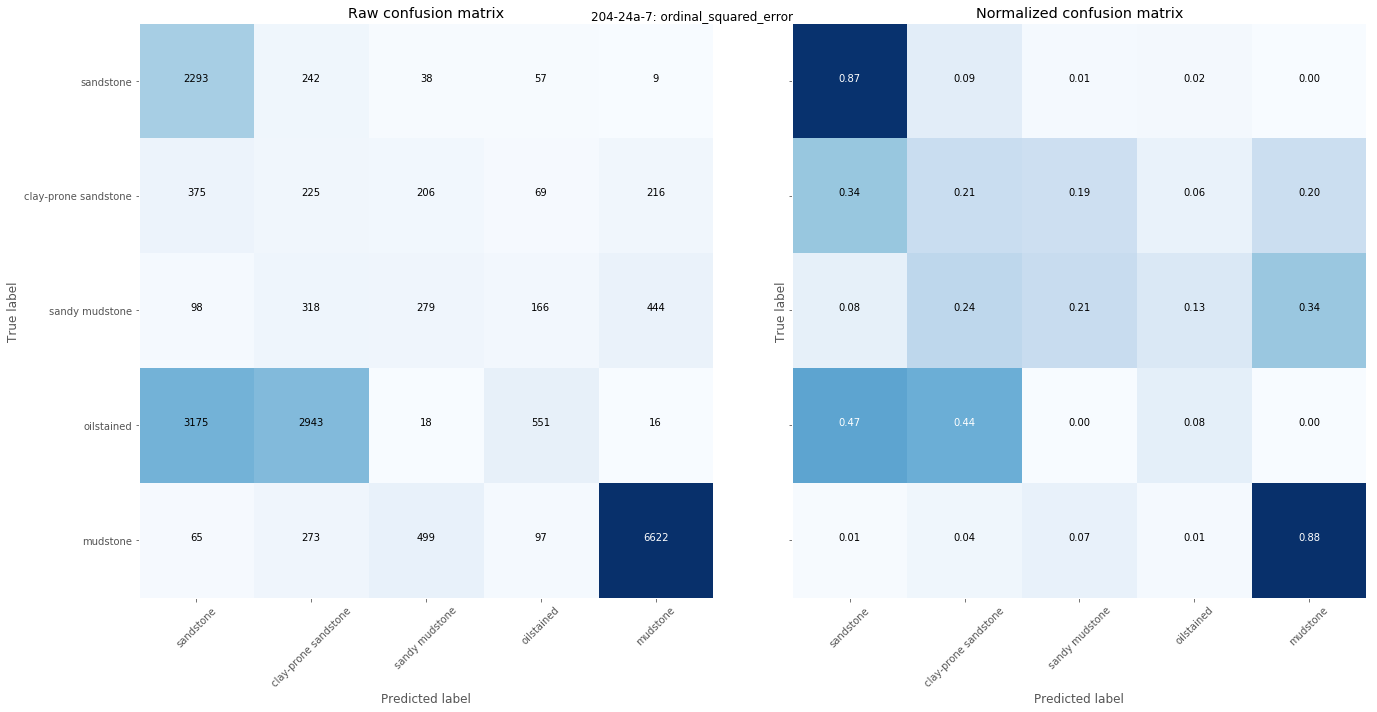


MODELING WITH LOSS: {'categorical_crossentropy': 0.2, 'ordinal_squared_error': 0.8}

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 4096, 8)      0                                            
__________________________________________________________________________________________________
conv1d_1320 (Conv1D)            (None, 4096, 64)     3648        input_21[0][0]                   
__________________________________________________________________________________________________
conv1d_1321 (Conv1D)            (None, 4096, 128)    24704       conv1d_1320[0][0]                
__________________________________________________________________________________________________
conv1d_1322 (Conv1D)            (None, 4096, 128)    24704       conv1d_1320[0][0]                
_______________________

Epoch 1/15
39/39 [==============================] - 59s 2s/step - loss: 2.1751 - acc: 0.3509 - val_loss: 1.2861 - val_acc: 0.1553
Epoch 2/15
39/39 [==============================] - 22s 553ms/step - loss: 0.9205 - acc: 0.5314 - val_loss: 1.0477 - val_acc: 0.4228
Epoch 3/15
39/39 [==============================] - 22s 558ms/step - loss: 0.7367 - acc: 0.6557 - val_loss: 0.8730 - val_acc: 0.5049
Epoch 4/15
39/39 [==============================] - 22s 566ms/step - loss: 0.6348 - acc: 0.7182 - val_loss: 1.1340 - val_acc: 0.4868
Epoch 5/15
39/39 [==============================] - 22s 558ms/step - loss: 0.6296 - acc: 0.7263 - val_loss: 1.0271 - val_acc: 0.5129
Epoch 6/15
39/39 [==============================] - 22s 557ms/step - loss: 0.5791 - acc: 0.7507 - val_loss: 1.0835 - val_acc: 0.4935
Epoch 7/15
39/39 [==============================] - 22s 560ms/step - loss: 0.5746 - acc: 0.7388 - val_loss: 1.0016 - val_acc: 0.5064
Epoch 8/15
39/39 [==============================] - 22s 560ms/step - los

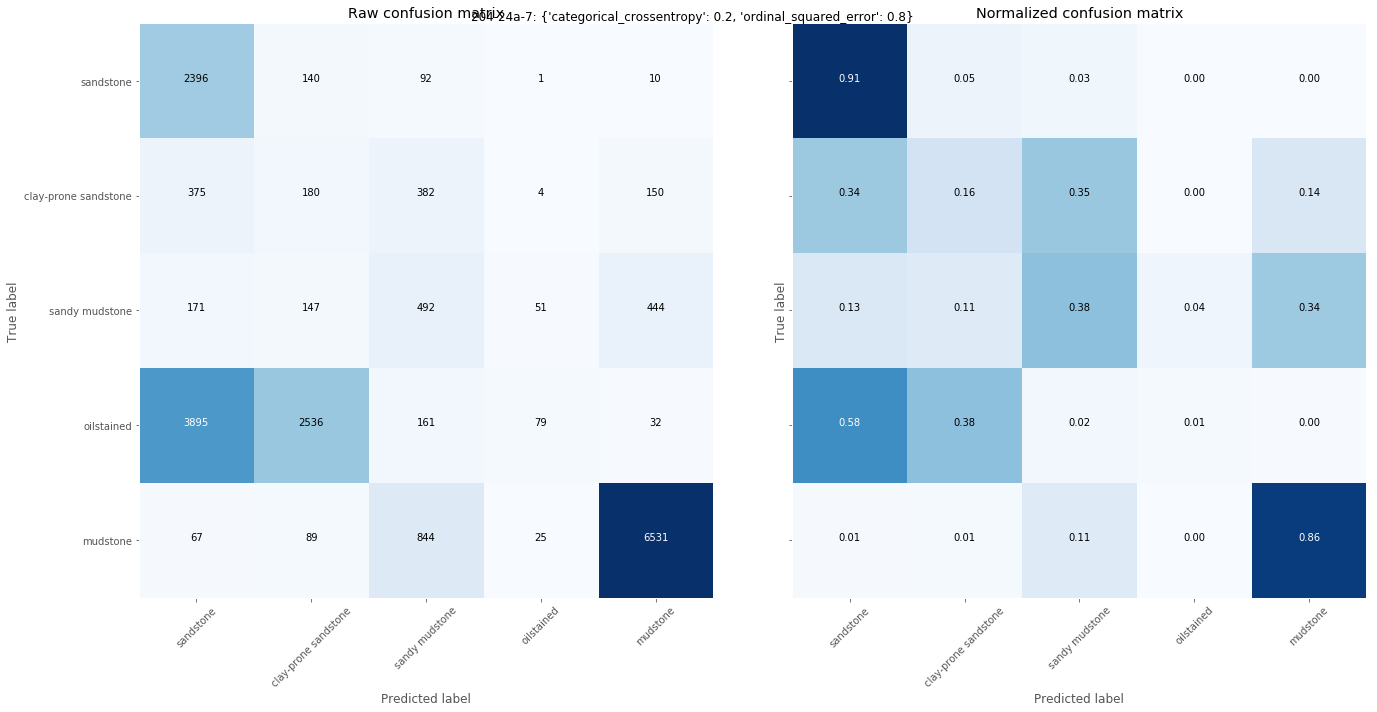

In [4]:
for test_well in well_names:
    
    print(f'\n\nTESTING WITH TEST WELL: {test_well}\n\n')
    
    fdset = FaciesDataset([name for name in well_names if name != test_well],
                    test_wells=[test_well],
                    features=["pseudoGR"],
                    label_resolution=32, 
                    pseudoGR_args={'scale_mode' : 'robust'})

    fdset.load_or_generate_data()
    
    for loss in loss_options:
        
        print(f'\nMODELING WITH LOSS: {loss}\n')
        
        model_args = {**wavenet_model_args, **{'loss': loss}}
        
        wavenet_model = NetworkModel(fdset, model_args=wavenet_model_args)
    
        wavenet_model.fit(fdset, **fit_args)
        
        y_pred = wavenet_model.predict(fdset.X_test)

        cm = confusion_matrix(fdset.y_test, y_pred)
        
        fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(20,10))
        fig.suptitle(f'{test_well}: {loss}')

        model_plots.confusion_matrix_plot(cm, fdset.classes, ax=ax[0])
        model_plots.confusion_matrix_plot(cm, fdset.classes, ax=ax[1], normalize=True)
        
        plt.show()

In [4]:
# What's up with this well -- all sand?
from coremdlr.viz import CorePlotter

fdset = Facies

well = fdset.get_well("204-20-1Z")

cplotter = CorePlotter(figsize=(10,200))
cplotter.plot_image(well._image / 255.0, depths=well._depth)

labels = well.make_striplog()
cplotter.plot_strip(labels)

plt.show()

NameError: name 'Facies' is not defined

## Categorical Loss

In [ ]:
well_names = ["205-21b-3", "204-20-6a", "204-20-1Z", "204-19-6", "204-24a-6"]

fdset = FaciesDataset(well_names[:-1], [well_names[-1]], features=['pseudoGR'], label_resolution=32)

fdset.load_or_generate_data()

In [ ]:
wavenet_model_args = {
    'feature' : 'pseudoGR',
    'network' : 'wavenet',
    'summary' : False,
    'sequence_size' : 128,
    'network_args' : {
        'num_blocks' : 20,
        'block_filters' : 128,
        'residual_filters' : 64,
        'output_resolution' : fdset.label_resolution,
        'dropout_rate' : 0.5,
    },
    'optimizer_args' : {
        'optimizer' : 'Adam',
    },
    'loss' : 'categorical_crossentropy'
}

fit_args = {
    'batch_size' : 32,
    'epochs' : 15,
    'step_size' : wavenet_model.sequence_size - 32
}



In [ ]:
fit_args = {
    'batch_size' : 32,
    'epochs' : 15,
    'step_size' : wavenet_model.sequence_size - 32
}

wavenet_model.fit(fdset, **fit_args)

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = wavenet_model.predict(fdset.X_test)

cm = confusion_matrix(fdset.y_test, y_pred)

model_plots.confusion_matrix_plot(cm, fdset.classes)

## Ordinal Loss

In [ ]:
wavenet_model_args['loss'] = 'ordinal_squared_error'

wavenet_model = NetworkModel(fdset, model_args=wavenet_model_args)

wavenet_model.fit(fdset, **fit_args)

In [ ]:
y_pred = wavenet_model.predict(fdset.X_test)

cm = confusion_matrix(fdset.y_test, y_pred)

model_plots.confusion_matrix_plot(cm, fdset.classes)

## Combined Loss

In [ ]:
wavenet_model_args['loss'] = {'categorical_crossentropy': 0.15, 
                              'ordinal_squared_error' : 0.85}

wavenet_model = NetworkModel(fdset, model_args=wavenet_model_args)

In [ ]:
wavenet_model.fit(fdset, **fit_args)

In [ ]:
y_pred = wavenet_model.predict(fdset.X_test)

cm = confusion_matrix(fdset.y_test, y_pred)

model_plots.confusion_matrix_plot(cm, fdset.classes)

## Try same with class weighting

In [ ]:
fit_args['class_weighted'] = True
fit_args['epochs'] = 9

wavenet_model = NetworkModel(fdset, model_args=wavenet_model_args)

wavenet_model.fit(fdset, **fit_args)

In [ ]:
y_pred = wavenet_model.predict(fdset.X_test)

cm = confusion_matrix(fdset.y_test, y_pred)

model_plots.confusion_matrix_plot(cm, fdset.classes)

In [ ]:
np.bincount(fdset.y_train) / fdset.y_train.size

In [ ]:
fit_args['class_weighted'] = True
fit_args['epochs'] = 30

wavenet_model = NetworkModel(fdset, model_args=wavenet_model_args)

wavenet_model.fit(fdset, **fit_args)